# Exploratory analysis of petTOAD dataframe (CN and MCI patients)

<div class="alert alert-block alert-info">
<b>Remember:</b> For this analysis you need to activate the `analysis` conda environment
</div>

This notebooks serves as a first exploratory analysis of white matter hyperintensities (WMH) volumes in cognitively normal (CN) subjects and patients with mild cognitive impairment (MCI). Data were taken from the Alzheimer's Disease Neuroinitiative (ADNI) database and then preprocessed with fmriprep/xcp_d. Furthermore WMH were calculated with deepNeuroSeg and visually checked and modified, as necessary. In particular, we have WMH volume data obtained in subject space and transformed from subject space to MNI2009in6cAsym space. Subjects are binned into WMH/no WMH respectively if the have a summed up Fazekas score (periventricular + deep) <=2 ("noWMH") or >2 ("WMH"). 


In [1]:
# Imports and directories
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from pathlib import Path

SPINE = Path.cwd().parents[2]
DATA_DIR = SPINE / "data"
UTL_DIR = DATA_DIR / "utils"
RES_DIR = SPINE / "results"

#Read in data
df_petTOAD_pre = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col = [0])
df_petTOAD_pre['WMH_bin'] = np.where(df_petTOAD_pre["Group_bin_Fazekas"].str.contains("no_WMH"), "no_WMH", "WMH")
df_petTOAD_pre["PTID"] = df_petTOAD_pre["PTID"].str.replace("_", "")
df_petTOAD = df_petTOAD_pre[df_petTOAD_pre["WMH_load_subj_space"] < 80000]

Let's first calculate some general summary statistics regarding sex, age and diagnosis.

In [60]:
n_pts = len(df_petTOAD)
age_min = round(df_petTOAD.describe()["Age"]["min"], 0)
age_max = round(df_petTOAD.describe()["Age"]["max"],0)
sex_counts = df_petTOAD['Sex'].value_counts()
DX_counts = df_petTOAD['Group'].value_counts()
females_num = sex_counts["F"]
males_num = sex_counts["M"]
cu_num = DX_counts['CN']
mci_num = DX_counts['MCI']

cu_no_wmh = len(df_petTOAD[df_petTOAD['Group_bin_Fazekas'] == 'CN_no_WMH'])
cu_wmh = len(df_petTOAD[df_petTOAD['Group_bin_Fazekas'] == 'CN_WMH'])
mci_no_wmh = len(df_petTOAD[df_petTOAD['Group_bin_Fazekas'] == 'MCI_no_WMH'])
mci_wmh = len(df_petTOAD[df_petTOAD['Group_bin_Fazekas'] == 'MCI_WMH'])

print(f"After exclusion, {n_pts} patients (age-range: {age_min}-{age_max}, {females_num} ({round(females_num / n_pts * 100, 2)}%) females, {males_num} ({round(males_num / n_pts * 100, 2)}%) males, {cu_num} ({round(cu_num / n_pts* 100, 1)}%) CU and {mci_num} ({round(mci_num / n_pts * 100, 1)}%) MCI) were considered for the modeling pipeline.")
print(f"Patients were further subdivided into subgroups according to the previously defined Fazekas score cutoff of <= 2.")
print(f"Accordingly, there were: {cu_no_wmh} ({round(cu_no_wmh / cu_num * 100, 1)}%) CU without WMH, {cu_wmh} ({round(cu_wmh / cu_num * 100, 1)}%) CU with WMH, {mci_no_wmh} ({round(mci_no_wmh / mci_num * 100, 1)}%) MCI without WMH, {mci_wmh} ({round(mci_wmh / mci_num* 100, 1)}%) MCI with WMH,")
# Create contingency table for comparing Fazekas binary classification between groups with Chi-squared
ct_wmh = pd.crosstab(df_petTOAD['WMH_bin'], df_petTOAD['Group'])
_, p_wmh, _, _ = ss.chi2_contingency(ct_wmh)
if p_wmh < 0.05:
    print(f"with statistically significant differences in frequency between subgroups (p = {round(p_wmh,3)})")
else:
    print(f"with no statistically significant differences in frequency between subgroups (p = {round(p_wmh, 3)})")

After exclusion, 187 patients (age-range: 56.0-90.0, 101 (54.01%) females, 86 (45.99%) males, 120 (64.2%) CU and 67 (35.8%) MCI) were considered for the modeling pipeline.
Patients were further subdivided into subgroups according to the previously defined Fazekas score cutoff of <= 2.
Accordingly, there were: 63 (52.5%) CU without WMH, 57 (47.5%) CU with WMH, 37 (55.2%) MCI without WMH, 30 (44.8%) MCI with WMH,
with no statistically significant differences in frequency between subgroups (p = 0.837)


In [78]:
# Get age summary stats
age_summary = df_petTOAD.groupby(["Group"])['Age'].describe()
age_summary_subgroups = df_petTOAD.groupby(["Group_bin_Fazekas"])['Age'].describe()
print("################# Results #################")
print("# Age #")
pval_age_diff_cn_vs_mci = ss.mannwhitneyu(df_petTOAD[df_petTOAD["Group"] == "CN"]["Age"], df_petTOAD[df_petTOAD["Group"] == "MCI"]["Age"])[1]
pval_age_diff_cn_no_wmh_vs_wmh = ss.mannwhitneyu(df_petTOAD[df_petTOAD["Group_bin_Fazekas"] == "CN_WMH"]["Age"], df_petTOAD[df_petTOAD["Group_bin_Fazekas"] == "CN_no_WMH"]["Age"])[1]
pval_age_diff_mci_no_wmh_vs_wmh = ss.mannwhitneyu(df_petTOAD[df_petTOAD["Group_bin_Fazekas"] == "MCI_WMH"]["Age"], df_petTOAD[df_petTOAD["Group_bin_Fazekas"] == "MCI_no_WMH"]["Age"])[1]
print(f"Median age for CU subjects = {age_summary['50%']['CN']} (IQR = {age_summary['25%']['CN']} - {age_summary['75%']['CN']})")
print(f"Median age for MCI subjects = {age_summary['50%']['MCI']} (IQR = {age_summary['25%']['MCI']} - {age_summary['75%']['MCI']})")
print(f"P-value age CU vs MCI: {round(pval_age_diff_cn_vs_mci, 5)}")

print(f"Median age for CU no WMH subjects = {age_summary_subgroups['50%']['CN_no_WMH']} (IQR = {age_summary_subgroups['25%']['CN_no_WMH']} - {age_summary_subgroups['75%']['CN_no_WMH']})")
print(f"Median age for CU WMH subjects = {age_summary_subgroups['50%']['CN_WMH']} (IQR = {age_summary_subgroups['25%']['CN_WMH']} - {age_summary_subgroups['75%']['CN_WMH']})")
print(f"P-value age CU no WMH vs CU WMH: {round(pval_age_diff_cn_no_wmh_vs_wmh, 5)}")

print(f"Median age for MCI no WMH subjects = {age_summary_subgroups['50%']['MCI_no_WMH']} (IQR = {age_summary_subgroups['25%']['MCI_no_WMH']} - {age_summary_subgroups['75%']['MCI_no_WMH']})")
print(f"Median age for MCI WMH subjects = {age_summary_subgroups['50%']['MCI_WMH']} (IQR = {age_summary_subgroups['25%']['MCI_WMH']} - {age_summary_subgroups['75%']['MCI_WMH']})")
print(f"P-value age MCI no WMH vs MCI WMH: {round(pval_age_diff_mci_no_wmh_vs_wmh, 5)}")


print("# WMH #")
wmh_summary = df_petTOAD.groupby(["Group"])['WMH_load_subj_space'].describe()
wmh_summary_subgroups = df_petTOAD.groupby(["Group_bin_Fazekas"])['WMH_load_subj_space'].describe()

pval_wmh_diff_cn_vs_mci= ss.mannwhitneyu(df_petTOAD[df_petTOAD["Group"] == "CN"]["WMH_load_subj_space"], df_petTOAD[df_petTOAD["Group"] == "MCI"]["WMH_load_subj_space"])[1]
pval_wmh_diff_cn_no_wmh_vs_wmh = ss.mannwhitneyu(df_petTOAD[df_petTOAD["Group_bin_Fazekas"] == "CN_WMH"]["WMH_load_subj_space"], df_petTOAD[df_petTOAD["Group_bin_Fazekas"] == "CN_no_WMH"]["WMH_load_subj_space"])[1]
pval_wmh_diff_mci_no_wmh_vs_wmh = ss.mannwhitneyu(df_petTOAD[df_petTOAD["Group_bin_Fazekas"] == "MCI_WMH"]["WMH_load_subj_space"], df_petTOAD[df_petTOAD["Group_bin_Fazekas"] == "MCI_no_WMH"]["WMH_load_subj_space"])[1]

print(f"Median WMH volume load for CN subjects = {wmh_summary['50%']['CN']} (IQR = {wmh_summary['25%']['CN']} - {wmh_summary['75%']['CN']})")
print(f"Median WMH volume load for MCI subjects = {wmh_summary['50%']['MCI']} (IQR = {wmh_summary['25%']['MCI']} - {wmh_summary['75%']['MCI']})")
print(f"P-value WMH volum CU vs MCI: {pval_wmh_diff_cn_vs_mci}")

print(f"Median WMH volume load for CN no WMH subjects = {wmh_summary_subgroups['50%']['CN_no_WMH']} (IQR = {wmh_summary_subgroups['25%']['CN_no_WMH']} - {wmh_summary_subgroups['75%']['CN_no_WMH']})")
print(f"Median WMH volume load for CN WMH subjects = {wmh_summary_subgroups['50%']['CN_WMH']} (IQR = {wmh_summary_subgroups['25%']['CN_WMH']} - {wmh_summary_subgroups['75%']['CN_WMH']})")
print(f"P-value WMH volume CU no WMH vs CU WMH: {pval_wmh_diff_cn_no_wmh_vs_wmh}")

print(f"Median WMH volume load for MCI no WMH subjects = {wmh_summary_subgroups['50%']['MCI_no_WMH']} (IQR = {wmh_summary_subgroups['25%']['MCI_no_WMH']} - {wmh_summary_subgroups['75%']['MCI_no_WMH']})")
print(f"Median WMH volume load for MCI WMH subjects = {wmh_summary_subgroups['50%']['MCI_WMH']} (IQR = {wmh_summary_subgroups['25%']['MCI_WMH']} - {wmh_summary_subgroups['75%']['MCI_WMH']})")
print(f"P-value WMH volume MCI no WMH vs MCI WMH: {pval_wmh_diff_mci_no_wmh_vs_wmh}")

print("# Sex #")
# Create contingency table for chi-squared
ct_sex = pd.crosstab(df_petTOAD['Sex'], df_petTOAD['Group'])
c_sex, p_sex, _, _ = ss.chi2_contingency(ct_sex)
if p_sex < 0.05:
    print(f"MCI and CU showed statistically significant sex differences, p = {round(p_sex, 3)}")
else:
    print(f"MCI and CU showed no sex groups differences, p = {round(p_sex,3)}")

# Create contingency table for chi-squared
ct_sex_wmh = pd.crosstab(df_petTOAD['Sex'], df_petTOAD['Group_bin_Fazekas'])
ct_sex_cn = ct_sex_wmh.iloc[:2,:2]
c_sex_cn, p_sex_cn, _, _ = ss.chi2_contingency(ct_sex_cn)
if p_sex_cn < 0.05:
    print(f"CU WMH and CU no WMH showed statistically significant sex differences, p = {round(p_sex_cn, 3)}")
else:
    print(f"CU WMH and CU no WMH showed no sex groups differences, p = {round(p_sex_cn,3)}")

# Create contingency table for chi-squared
ct_sex_mci = ct_sex_wmh.iloc[:2,2:]
c_sex_mci, p_sex_mci, _, _ = ss.chi2_contingency(ct_sex_mci)
if p_sex_mci < 0.05:
    print(f"CU WMH and CU no WMH showed statistically significant sex differences, p = {round(p_sex_mci, 3)}")
else:
    print(f"MCI WMH and MCI no WMH showed no sex groups differences, p = {round(p_sex_mci,3)}")

################# Results #################
# Age #
Median age for CU subjects = 69.5 (IQR = 66.0 - 76.0)
Median age for MCI subjects = 72.0 (IQR = 68.5 - 79.0)
P-value age CU vs MCI: 0.04056
Median age for CU no WMH subjects = 68.0 (IQR = 66.0 - 71.5)
Median age for CU WMH subjects = 73.0 (IQR = 68.0 - 77.0)
P-value age CU no WMH vs CU WMH: 0.00055
Median age for MCI no WMH subjects = 71.0 (IQR = 65.0 - 76.0)
Median age for MCI WMH subjects = 76.5 (IQR = 72.0 - 79.75)
P-value age MCI no WMH vs MCI WMH: 0.00234
# WMH #
Median WMH volume load for CN subjects = 4686.0 (IQR = 2054.75 - 11644.75)
Median WMH volume load for MCI subjects = 4499.0 (IQR = 2284.5 - 11911.5)
P-value WMH volum CU vs MCI: 0.7501874006956432
Median WMH volume load for CN no WMH subjects = 2083.0 (IQR = 912.35 - 3446.4)
Median WMH volume load for CN WMH subjects = 12202.0 (IQR = 6950.0 - 23818.8)
P-value WMH volume CU no WMH vs CU WMH: 1.5071688009900786e-17
Median WMH volume load for MCI no WMH subjects = 2456.0 (I

In [104]:
# Create a summary DataFrame
summary_data = {
    "Age Median (IQR)": [
        f"{age_summary_subgroups['50%']['CN_no_WMH']} ({age_summary_subgroups['25%']['CN_no_WMH']} - {age_summary_subgroups['75%']['CN_no_WMH']})",
        f"{age_summary_subgroups['50%']['CN_WMH']} ({age_summary_subgroups['25%']['CN_WMH']} - {age_summary_subgroups['75%']['CN_WMH']})",
        f"{round(pval_age_diff_cn_no_wmh_vs_wmh, 3)}",
        f"{age_summary_subgroups['50%']['MCI_no_WMH']} ({age_summary_subgroups['25%']['MCI_no_WMH']} - {age_summary_subgroups['75%']['MCI_no_WMH']})",
        f"{age_summary_subgroups['50%']['MCI_WMH']} ({age_summary_subgroups['25%']['MCI_WMH']} - {age_summary_subgroups['75%']['MCI_WMH']})",
        f"{round(pval_age_diff_mci_no_wmh_vs_wmh, 3)}",
    ],
    "Sex n (%)": ["", "", round(p_sex_cn, 3), "", "", round(p_sex_mci)],
    "Woman": [
        f"{ct_sex_cn['CN_no_WMH']['F']} ({round(ct_sex_cn['CN_no_WMH']['F'] / ct_sex_cn['CN_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_cn['CN_WMH']['F']} ({round(ct_sex_cn['CN_WMH']['F'] / ct_sex_cn['CN_WMH'].sum() * 100, 1)}%)",
        "",
        f"{ct_sex_mci['MCI_no_WMH']['F']} ({round(ct_sex_mci['MCI_no_WMH']['F'] / ct_sex_mci['MCI_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_mci['MCI_WMH']['F']} ({round(ct_sex_mci['MCI_WMH']['F'] / ct_sex_mci['MCI_WMH'].sum() * 100, 1)}%)",
        ""
    ],
    "Man": [
        f"{ct_sex_cn['CN_no_WMH']['M']} ({round(ct_sex_cn['CN_no_WMH']['M'] / ct_sex_cn['CN_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_cn['CN_WMH']['M']} ({round(ct_sex_cn['CN_WMH']['M'] / ct_sex_cn['CN_WMH'].sum() * 100, 1)}%)",
        "",
        f"{ct_sex_mci['MCI_no_WMH']['M']} ({round(ct_sex_mci['MCI_no_WMH']['M'] / ct_sex_mci['MCI_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_mci['MCI_WMH']['M']} ({round(ct_sex_mci['MCI_WMH']['M'] / ct_sex_mci['MCI_WMH'].sum() * 100, 1)}%)",
        ""
    ],
    "WMH volume (mm^3)": [
        f"{int(wmh_summary_subgroups['50%']['CN_no_WMH'])} ({int(wmh_summary_subgroups['25%']['CN_no_WMH'])}-{int(wmh_summary_subgroups['75%']['CN_no_WMH'])})",
        f"{int(wmh_summary_subgroups['50%']['CN_WMH'])} ({int(wmh_summary_subgroups['25%']['CN_WMH'])}-{int(wmh_summary_subgroups['75%']['CN_WMH'])})",
        f"{round(pval_wmh_diff_cn_no_wmh_vs_wmh, 5)}",
        f"{int(wmh_summary_subgroups['50%']['MCI_no_WMH'])} ({int(wmh_summary_subgroups['25%']['MCI_no_WMH'])}-{int(wmh_summary_subgroups['75%']['MCI_no_WMH'])})",
        f"{int(wmh_summary_subgroups['50%']['MCI_WMH'])} ({int(wmh_summary_subgroups['25%']['MCI_WMH'])}-{int(wmh_summary_subgroups['75%']['MCI_WMH'])})",
        f"{round(pval_wmh_diff_mci_no_wmh_vs_wmh, 5)}",
    ],
}

# Create the summary DataFrame
df_summary = pd.DataFrame(data=summary_data)

# Print the summary DataFrame
df_table1 = df_summary.T
df_table1.columns = [f"CU no WMH (n = {cu_no_wmh})", f"CU WMH (n = {cu_wmh})",  "p", f"MCI no WMH (n = {mci_no_wmh})", f"MCI WMH (n = {mci_wmh})", "p"]
df_table1.to_csv(RES_DIR / "table_1.csv")
df_table1

,CU no WMH (n = 63),CU WMH (n = 57),p,MCI no WMH (n = 37),MCI WMH (n = 30),p
Age Median (IQR),68.0 (66.0 - 71.5),73.0 (68.0 - 77.0),0.001,71.0 (65.0 - 76.0),76.5 (72.0 - 79.75),0.002
Sex n (%),,,0.494,,,1
Woman,36 (57.1%),37 (64.9%),,15 (40.5%),13 (43.3%),
Man,27 (42.9%),20 (35.1%),,22 (59.5%),17 (56.7%),
WMH volume (mm^3),2083 (912-3446),12202 (6950-23818),0.0,2456 (1629-4416),13134 (6362-21871),0.0


In [100]:

# Create a summary DataFrame
summary_data = {
    "Age Median (IQR)": [
        f"{age_summary['50%']['CN']} ({age_summary['25%']['CN']} - {age_summary['75%']['CN']})",
        f"{age_summary['50%']['MCI']} ({age_summary['25%']['MCI']} - {age_summary['75%']['MCI']})",
        f"{round(pval_age_diff_cn_vs_mci, 4)}"], 
    "Sex n (%)": ["", "", round(p_sex, 3)],
    "Woman": [f"{ct_sex.iloc[0, 0]} ({round(ct_sex.iloc[0, 0]/cu_num * 100, 1)}%)", f"{ct_sex.iloc[0, 1]} ({round(ct_sex.iloc[0, 1] / mci_num * 100, 1)}%)", ""],
    "Man": [f"{ct_sex.iloc[1, 0]} ({round(ct_sex.iloc[1, 0]/cu_num * 100, 1)}%)", f"{ct_sex.iloc[1, 1]} ({round(ct_sex.iloc[1, 1] / mci_num * 100, 1)}%)", ""],
    "WMH volume (mm^3)": [
        f"{int(wmh_summary['50%']['CN'])} ({int(wmh_summary['25%']['CN'])}-{int(wmh_summary['75%']['CN'])})",
        f"{int(wmh_summary['50%']['MCI'])} ({int(wmh_summary['25%']['MCI'])}-{int(wmh_summary['75%']['MCI'])})",
        f"{round(pval_wmh_diff_cn_vs_mci, 3)}"],
    "Fazekas score binned n (%)": ["", "", round(p_wmh, 3)],
    "WMH": [f"{ct_wmh.iloc[0, 0]} ({round(ct_wmh.iloc[0, 0]/cu_num * 100, 1)}%)", f"{ct_wmh.iloc[0, 1]} ({round(ct_wmh.iloc[0, 1] / mci_num * 100, 1)}%)", ""],
    "no WMH": [f"{ct_wmh.iloc[1, 0]} ({round(ct_wmh.iloc[1, 0]/cu_num * 100, 1)}%)", f"{ct_wmh.iloc[1, 1]} ({round(ct_wmh.iloc[1, 1] / mci_num * 100, 1)}%)", ""],}

# Create the summary DataFrame
df_summary = pd.DataFrame(data = summary_data)

# Print the summary DataFrame
df_table1_bis = df_summary.T
df_table1_bis.columns = [f"CU, n = {cu_num}", f"MCI, n = {mci_num}", "p-value"]
df_table1_bis.to_csv(RES_DIR / "table_1_group_together.csv")
df_table1_bis

,"CU, n = 120","MCI, n = 67",p-value
Age Median (IQR),69.5 (66.0 - 76.0),72.0 (68.5 - 79.0),0.0406
Sex n (%),,,0.019
Woman,73 (60.8%),28 (41.8%),
Man,47 (39.2%),39 (58.2%),
WMH volume (mm^3),4686 (2054-11644),4499 (2284-11911),0.75
Fazekas score binned n (%),,,0.837
WMH,57 (47.5%),30 (44.8%),
no WMH,63 (52.5%),37 (55.2%),


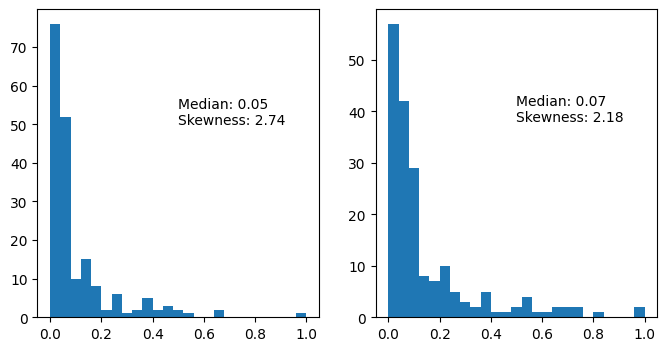

In [53]:
wmh_pre = (
        df_petTOAD_pre["WMH_load_subj_space"] - df_petTOAD_pre["WMH_load_subj_space"].min()
    ) / (
        df_petTOAD_pre["WMH_load_subj_space"].max() - df_petTOAD_pre["WMH_load_subj_space"].min()
    )
wmh_post = (
        df_petTOAD["WMH_load_subj_space"] - df_petTOAD["WMH_load_subj_space"].min()
    ) / (
        df_petTOAD["WMH_load_subj_space"].max() - df_petTOAD["WMH_load_subj_space"].min()
    )
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist(wmh_pre, bins = 25);
plt.annotate(f"Median: {round(wmh_pre.median(), 2)}\nSkewness: {round(ss.skew(wmh_pre), 2)}", (0.5, 50))
plt.subplot(122)
plt.hist(wmh_post, bins = 25);
plt.annotate(f"Median: {round(wmh_post.median(), 2)}\nSkewness: {round(ss.skew(wmh_post), 2)}", (0.5, 38))
plt.savefig(RES_DIR / "distribution_pre_post_normalized_WMH.png")